In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [2]:
with open("names.txt", "r") as f:
    words = f.read().splitlines()
chars = ["."] + sorted(list(set("".join(words))))
stoi = {c: i for i, c in enumerate(chars)}
itos = {i: c for i, c in enumerate(chars)}
block_size = 3
vocab_size = len(itos)
embedding_size = 10
hidden_size = 200

In [3]:
def build_dataset(words, block_size):
    X, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(y)


def split_dataset(words):
    random.seed(42)
    random.shuffle(words)
    n1 = int(0.8 * len(words))
    n2 = int(0.9 * len(words))
    train = words[:n1]
    dev = words[n1:n2]
    test = words[n2:]
    X_train, y_train = build_dataset(train, block_size)
    X_dev, y_dev = build_dataset(dev, block_size)
    X_test, y_test = build_dataset(test, block_size)
    return X_train, y_train, X_dev, y_dev, X_test, y_test


X_train, y_train, X_dev, y_dev, X_test, y_test = split_dataset(words)

In [4]:
g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, embedding_size), generator=g)
W1 = torch.randn((block_size * embedding_size, hidden_size), generator=g) * 0.2
b1 = torch.randn(hidden_size, generator=g) * 0.01
W2 = torch.randn((hidden_size, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) *0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [5]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    ix = torch.randint(0, len(X_train), (batch_size,))
    Xb, yb = X_train[ix], y_train[ix]
    emb = C[Xb]
    emb_cat = emb.view(-1, block_size * embedding_size)
    hpreact = emb_cat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, yb)
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    if i % 10000 == 0:
        print(f"{i} / {max_steps}, loss: {loss.item()}")
    lossi.append(loss.log10().item())

0 / 200000, loss: 3.3016467094421387
10000 / 200000, loss: 2.2426767349243164
20000 / 200000, loss: 2.2842884063720703
30000 / 200000, loss: 2.2648355960845947
40000 / 200000, loss: 2.0095393657684326
50000 / 200000, loss: 2.253190040588379
60000 / 200000, loss: 2.1510255336761475
70000 / 200000, loss: 1.8224754333496094
80000 / 200000, loss: 1.9211606979370117
90000 / 200000, loss: 2.5105350017547607
100000 / 200000, loss: 2.0424699783325195
110000 / 200000, loss: 2.573119878768921
120000 / 200000, loss: 1.8661221265792847
130000 / 200000, loss: 2.17533540725708
140000 / 200000, loss: 2.0310795307159424
150000 / 200000, loss: 1.9927804470062256
160000 / 200000, loss: 2.1461024284362793
170000 / 200000, loss: 1.8872126340866089
180000 / 200000, loss: 1.8809157609939575
190000 / 200000, loss: 1.8441823720932007


(array([1110.,  265.,  156.,  121.,   98.,  105.,   83.,   92.,   61.,
          79.,   63.,   64.,   63.,   48.,   59.,   60.,   62.,   47.,
          68.,   58.,   90.,   54.,   89.,   68.,  111.,   67.,   94.,
          95.,   72.,   59.,   65.,   59.,   69.,   59.,   67.,   51.,
          62.,   77.,   66.,   58.,   80.,   76.,   71.,   80.,   92.,
         103.,  117.,  151.,  250., 1186.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

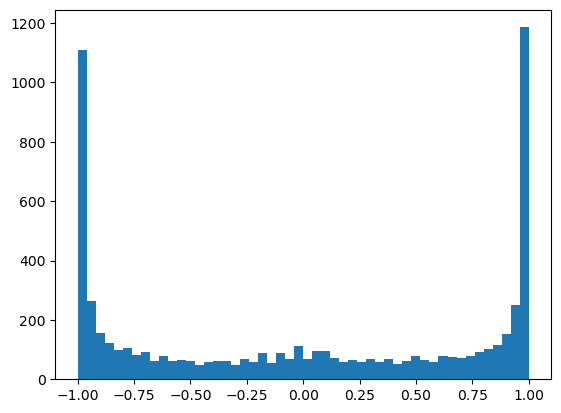

In [6]:
plt.hist(h.view(-1).tolist(),bins=50)

(array([  2.,   1.,   0.,   0.,   1.,   7.,   8.,  10.,  16.,  16.,  18.,
         28.,  55.,  59.,  84., 101., 131., 156., 208., 228., 285., 310.,
        381., 457., 674., 649., 452., 352., 295., 262., 260., 203., 165.,
        129.,  90.,  75.,  58.,  48.,  44.,  24.,  20.,   8.,  12.,   6.,
          5.,   1.,   2.,   1.,   1.,   2.]),
 array([-9.7458334 , -9.3544593 , -8.96308521, -8.57171112, -8.18033703,
        -7.78896294, -7.39758884, -7.00621475, -6.61484066, -6.22346657,
        -5.83209248, -5.44071838, -5.04934429, -4.6579702 , -4.26659611,
        -3.87522202, -3.48384792, -3.09247383, -2.70109974, -2.30972565,
        -1.91835155, -1.52697746, -1.13560337, -0.74422928, -0.35285519,
         0.03851891,  0.429893  ,  0.82126709,  1.21264118,  1.60401527,
         1.99538937,  2.38676346,  2.77813755,  3.16951164,  3.56088573,
         3.95225983,  4.34363392,  4.73500801,  5.1263821 ,  5.5177562 ,
         5.90913029,  6.30050438,  6.69187847,  7.08325256,  7.47462666,
 

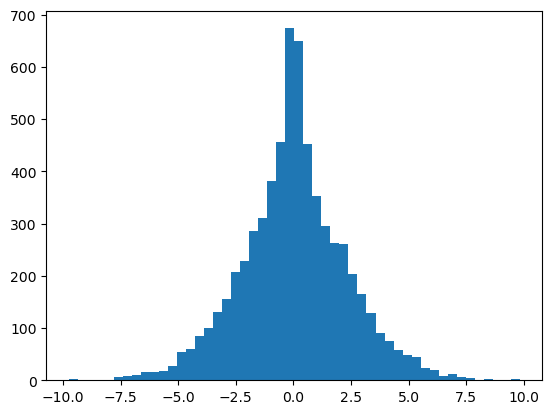

In [7]:
plt.hist(hpreact.view(-1).tolist(),bins=50)

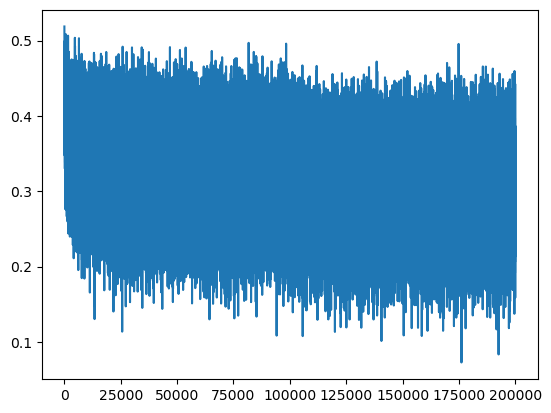

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad()
def split_loss(split):
    X, y = {
        "train": (X_train, y_train),
        "val": (X_dev, y_dev),
        "test": (X_test, y_test),
    }[split]
    emb = C[X]
    emb_cat = emb.view(-1, block_size * embedding_size)
    hpreact = emb_cat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.0358200073242188
val 2.1027121543884277


In [10]:
# sample from the model
g = torch.Generator().manual_seed(10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        
        out.append(ix)
        if ix==0:
            break
    print("".join(itos[i] for i in out))

pri.
ehla.
meib.
jeninatom.
dayanna.
jassiquety.
yanju.
jacimberleighthorrah.
arie.
ellareliya.
delithan.
arius.
thika.
nes.
marshan.
audhensietta.
jaydynn.
izzaida.
sana.
rome.
